# GAN for Generating Synthetic Data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.metrics import auc
import pickle
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from ctgan import CTGAN
from sklearn.base import BaseEstimator, TransformerMixin

# 1. Under-sampling and One-Hot Encoding

In [82]:
base=pd.read_csv('./datasets/processed_base.csv')
base.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.3,0.986506,25.0,40,0.006735,AA,1059,13096.035018,7850.955007,...,9.0,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0
1,0,0.8,0.617426,89.0,20,0.010095,AD,1658,9223.283431,5745.251481,...,2.0,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0
2,0,0.8,0.996707,14.0,40,0.012316,AB,1095,4471.472149,5471.988958,...,30.0,0,200.0,0,INTERNET,22.730559,windows,0,1.0,0
3,0,0.6,0.475100,14.0,30,0.006991,AB,3483,14431.993621,6755.344479,...,1.0,0,200.0,0,INTERNET,15.215816,linux,1,1.0,0
4,0,0.9,0.842307,29.0,40,5.742626,AA,2339,7601.511579,5124.046930,...,26.0,0,200.0,0,INTERNET,3.743048,other,0,1.0,0


In [54]:
# 下采样函数
def undersample_majority_class(x, y, ratio=10, strategy='nearmiss'):
    minority_class_size = np.sum(y == 1)
    majority_class_size = minority_class_size * ratio
    
    if strategy == 'random':
        undersample = RandomUnderSampler(sampling_strategy={0: majority_class_size, 1: minority_class_size}, random_state=42)
    elif strategy == 'nearmiss':
        undersample = NearMiss(sampling_strategy=1/ratio, n_jobs=-1)
    elif strategy == 'iht':
        # clf = RandomForestClassifier(random_state=42,n_jobs=-1)
        clf = XGBClassifier(n_jobs=-1, random_state=42)
        undersample = InstanceHardnessThreshold(estimator=clf, sampling_strategy=0.1,n_jobs=-1)  
    else:
        raise ValueError("Unsupported strategy. Use 'random', 'nearmiss', or 'iht'.")
    
    x_resampled, y_resampled = undersample.fit_resample(x, y)
    return x_resampled, y_resampled

In [83]:
# one-hot encoding
def one_hot_encoding(data):
    # 需要进行One-Hot Encoding的分类变量
    categorical_features = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    
    # 使用pd.get_dummies进行One-Hot Encoding
    # drop_first=True表示删除第一个类别，避免多重共线性,同时避免引入不必要的特征并且保留了所有信息
    # 此时先用False保留所有特征，后续建立模型时候可以选择drop_first=True来避免多重共线性并减少特征数量
    data_encoded = pd.get_dummies(data, columns=categorical_features,drop_first=False)
    
    # 找出新生成的 One-Hot 编码列
    encoded_columns = data_encoded.columns.difference(data.columns)
    
    # 将 One-Hot 编码列转换为整数类型
    data_encoded[encoded_columns] = data_encoded[encoded_columns].astype(int)
    
    return data_encoded

# 示例预处理
df = one_hot_encoding(base)
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,25.0,40,0.006735,1059,13096.035018,7850.955007,6742.080561,...,0,0,0,1,0,1,0,0,0,0
1,0,0.8,0.617426,89.0,20,0.010095,1658,9223.283431,5745.251481,5941.664859,...,0,0,0,1,0,0,0,1,0,0
2,0,0.8,0.996707,14.0,40,0.012316,1095,4471.472149,5471.988958,5992.555113,...,0,0,0,1,0,0,0,0,1,0
3,0,0.6,0.475100,14.0,30,0.006991,3483,14431.993621,6755.344479,5970.336831,...,0,0,0,1,0,1,0,0,0,0
4,0,0.9,0.842307,29.0,40,5.742626,2339,7601.511579,5124.046930,5940.734212,...,0,0,0,1,0,0,0,1,0,0


In [84]:
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

# 检查数据类型并识别分类变量
original_categorical_columns = base.select_dtypes(include=['object', 'category']).columns.tolist()

# 识别one-hot编码后的分类列
categorical_columns = [col for col in X.columns if any(orig_col in col for orig_col in original_categorical_columns)]

X_nm, y_nm = undersample_majority_class(X, y, ratio=10, strategy='iht')
y.value_counts(),y_nm.value_counts()

(fraud_bool
 0    982612
 1     10995
 Name: count, dtype: int64,
 fraud_bool
 0    109967
 1     10995
 Name: count, dtype: int64)

In [93]:
# split
x_train, x_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.2, random_state=42, shuffle=True)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(Counter(y_train),Counter(y_test))

numeric_features_name=[x for x in df.columns if df[x].nunique() >= 10]

numeric_features = df[numeric_features_name]

# 创建 MinMaxScaler 实例
numeric_transformer = MinMaxScaler()

# 创建 ColumnTransformer
preprocessor = ColumnTransformer([('scaled', numeric_transformer, numeric_features_name)], remainder='passthrough')

# 在训练集上拟合并转换
x_train_scaled = preprocessor.fit_transform(x_train)

# 仅转换测试集
x_test_scaled = preprocessor.transform(x_test)

# 获取列的顺序(colmuntransformer会改变列的顺序)
new_columns = numeric_features_name + [col for col in x_train.columns if col not in numeric_features_name]

# 转换后的结果通常为 NumPy 数组，将其转换回 DataFrame 并保持列名一致性
x_train_scaled = pd.DataFrame(x_train_scaled, columns=new_columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=new_columns)

# # 确定分类特征的名称
categorical_features_name = [col for col in x_train_scaled.columns if 2 <= x_train_scaled[col].nunique() < 10]

# 确定分类特征的索引
all_features = list(x_train_scaled.columns)  # 所有特征的名称列表
categorical_feature_indices = [i for i, feature in enumerate(all_features) if feature in categorical_features_name]

print("分类特征名称：", categorical_features_name)
print("分类特征索引：", categorical_feature_indices)

Counter({0: 87914, 1: 8855}) Counter({0: 22053, 1: 2140})
分类特征名称： ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11']
分类特征索引： [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


# 2. GAN

In [109]:
# 确保 x_train_scaled 和 y_train 的索引一致
x_train_scaled = x_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# 合并训练集
train_data = pd.concat([x_train_scaled, y_train], axis=1)
train_data.columns = list(x_train_scaled.columns) + ['fraud_bool']

# 将训练集分为少数类和多数类
minority_class = train_data[train_data['fraud_bool'] == 1]
majority_class = train_data[train_data['fraud_bool'] == 0]


In [111]:
# 训练GAN
# 原始数据的分类列
original_categorical_columns = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

# 识别one-hot编码后的分类列
categorical_columns = [col for col in x_train.columns if any(orig_col in col for orig_col in original_categorical_columns)]

# 分离少数类特征
minority_features = minority_class.drop(['fraud_bool'], axis=1)

# 设置CTGAN的参数
embedding_dim = 128
generator_dim = (256, 256)
discriminator_dim = (256, 256)
batch_size = 500
log_frequency = True
verbose = True
epochs = 300

# 创建CTGAN实例
ctgan = CTGAN(
    embedding_dim=embedding_dim,
    generator_dim=generator_dim,
    discriminator_dim=discriminator_dim,
    batch_size=batch_size,
    log_frequency=log_frequency,
    verbose=verbose,
    epochs=epochs
)

# 创建并训练CTGAN模型
ctgan.fit(minority_features, categorical_columns, epochs=epochs)

Gen. (-5.96) | Discrim. (0.27): 100%|██████████| 300/300 [05:36<00:00,  1.12s/it] 


In [112]:
# 生成所需的少数类样本
num_samples_to_generate = len(majority_class) - len(minority_class)
new_minority_data = ctgan.sample(num_samples_to_generate)

# 创建一个新的DataFrame用于平衡数据集
new_minority_data['fraud_bool'] = 1

# 将新生成的少数类样本与原始数据合并
balanced_data = pd.concat([train_data, new_minority_data], ignore_index=True)

# 检查新生成的数据
balanced_data['fraud_bool'].value_counts()

x_train_scaled = balanced_data.drop(['fraud_bool'], axis=1)
y_train = balanced_data['fraud_bool']

## 2.1 Training

In [114]:
def train_classifier(classifier, param_dist, X_train, y_train, encoded_features, search_type='random', scoring='roc_auc', iterations=10,resample=False):
    
    # 转换为numpy数组并确保数据类型高效
    X_train = np.array(X_train).astype(np.float32)
    y_train = np.array(y_train).astype(np.int32)
    
    # 创建交叉验证策略
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 选择评分方法
    if scoring == 'f1':
        scoring_method = make_scorer(f1_score, pos_label=1)  # pos_label=1 表示正类标签为1
    elif scoring == 'recall':
        scoring_method = make_scorer(recall_score, pos_label=1)
    else:
        scoring_method = scoring

    # 构建采样和模型管道
    if resample:
        smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42, n_jobs=-1)
        pipeline = make_pipeline(smote_nc, classifier)
    else:
        pipeline = make_pipeline(classifier)
    
    # 进行超参数搜索
    if search_type == 'random':
        search_cv = RandomizedSearchCV(estimator=pipeline, 
                                       param_distributions=param_dist,
                                       n_iter=iterations,
                                       scoring=scoring_method,
                                       n_jobs=-1,
                                       cv=cv,
                                       verbose=2)
    elif search_type == 'grid':
        search_cv = GridSearchCV(estimator=pipeline,
                                 param_grid=param_dist,
                                 scoring=scoring_method,
                                 n_jobs=-1,
                                 cv=cv,
                                 verbose=2)
    else:
        raise ValueError('search_type 必须是 "random" 或 "grid"')
        
    # 拟合模型并返回训练好的分类器
    search_cv.fit(X_train, y_train)

    return search_cv

## 2.2 Evaluation

In [117]:
# print classification report
def print_cls_report(y_test, y_pred, title="Classification Report"):
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report["1"]["recall"]
    print(f"{title}:\n", classification_report(y_test, y_pred))
    return recall

# print cv results
def print_cv_results(model):
    # Get the parameter and score arrays from the cv_results_ dictionary
    means = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']

    # Combine the arrays using zip()
    combined_results = zip(means, params)

    # Sort the combined array by mean_test_score in descending order
    sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

    # Print the mean test score and the hyperparameters as a formatted string
    for mean, param in sorted_results:
        print("mean_test_score: %f, params: %r" % (mean, param))

# plot roc curve
def plot_roc_curves(fpr_list, tpr_list, label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr_list)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr_list[i], tpr_list[i])
        # Plot the ROC curve
        plt.plot(fpr_list[i], tpr_list[i], label=f'{label_list[i]} (AUC={roc_auc_score:.2f})')
    
    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# my_palette = sns.color_palette("husl", 2)

# plot confusion matrix
def plot_con_matrix(ax, y_test, y_pred, title):
    # Define the classes of the classification problem
    classes = ['No Fraud', 'Fraud']

    # Compute the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    # Compute the values for true negatives, false positives, false negatives, and true positives
    tn, fp, fn, tp = con_matrix.ravel()

    # Compute the false positive rate
    fpr = fp / (fp + tn)

    # Plot the confusion matrix using a heatmap
    # ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.GnBu,alpha=0.7)
    
    # Define the tick marks and the labels for the plot
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add the count of each cell of the confusion matrix to the plot
    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    # Add labels to the plot
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

In [118]:
# labels = y_test
groups = (x_test["customer_age"] > 50).map({True: ">50", False: "<=50"}) 

# Define a function to calculate fairness metrics
def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()
    return predictive_equality, disparities_df

# Evaluate Function
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test, groups):
    y_train_pred = classifier.predict(x_train)
    y_pred = classifier.predict(x_test)
    y_prob = classifier.predict_proba(x_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    target_fpr = 0.05  # Set the target threshold at 5% FPR
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]
    
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    train_set = print_cls_report(y_train, y_train_pred, title="Train Set")
    default_recall = print_cls_report(y_test, y_pred, title="Default Threshold")
    target_recall = print_cls_report(y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')
    
    default_predictive_equality, default_disparities_df = get_fairness_metrics(y_test, y_pred, groups, 0.5)
    target_predictive_equality, target_disparities_df = get_fairness_metrics(y_test, y_pred_threshold, groups, target_fpr)
    
    print(f"Default Predictive Equality: {default_predictive_equality:.2f}")
    print(f"Target Predictive Equality: {target_predictive_equality:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    default_matrix = plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    target_matrix = plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    plt.tight_layout()
    plt.show()

    return fpr, tpr, default_recall, target_recall, default_predictive_equality, target_predictive_equality


# 3. Random Forest

In [119]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for RandomForestClassifier
rf_params = {'randomforestclassifier__n_estimators': [ 60, 80, 100,120],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
            'randomforestclassifier__max_features': ['sqrt', 'log2']
            }
# # 使用imblearn的Pipeline时命名方式区别于make_pipe
# rf_params = {
#     'classifier__n_estimators': [60, 80, 100, 120],
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__max_depth': [2, 4, 6, 8, 10],
#     'classifier__max_features': ['sqrt', 'log2']
# }

rf_model = train_classifier(classifier=rf, param_dist=rf_params, X_train=x_train_scaled, y_train=y_train, encoded_features=categorical_feature_indices, resample=False, search_type='random', scoring='roc_auc', iterations=20)

print('best params for rf:',rf_model.best_params_,'\n')

print(print_cv_results(rf_model))

best params for rf: {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy'} 

mean_test_score: 0.985239, params: {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy'}
mean_test_score: 0.984964, params: {'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy'}
mean_test_score: 0.984524, params: {'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini'}
mean_test_score: 0.984035, params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'log2', 'randomforestclassi

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
E:\Programming\anaconda3\envs\mytorch\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Train Set:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     87914
           1       1.00      0.97      0.99     87914

    accuracy                           0.99    175828
   macro avg       0.99      0.99      0.99    175828
weighted avg       0.99      0.99      0.99    175828

Default Threshold:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     22053
           1       0.99      0.72      0.84      2140

    accuracy                           0.97     24193
   macro avg       0.98      0.86      0.91     24193
weighted avg       0.98      0.97      0.97     24193

Target Threshold @ 0.11:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22053
           1       0.65      0.96      0.77      2140

    accuracy                           0.95     24193
   macro avg       0.82      0.95      0.87     24193
weighted avg    

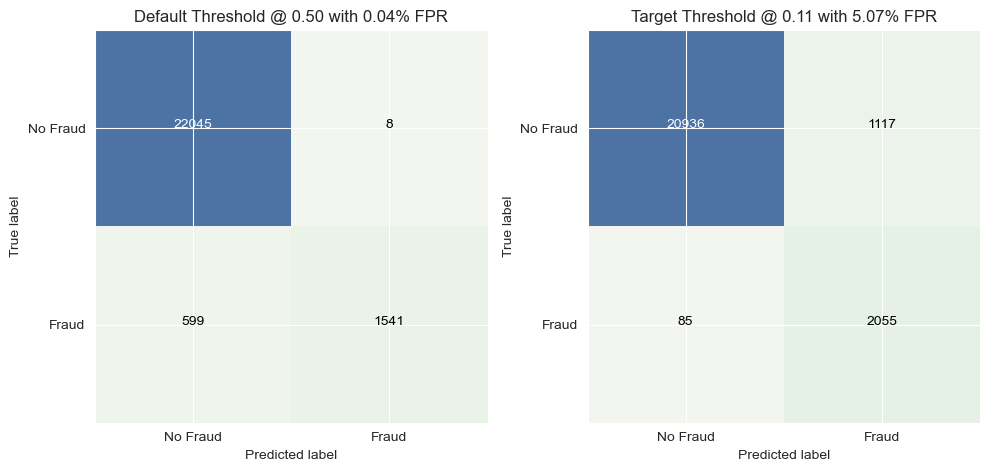

In [120]:
# Evaluate the Random Forest Classifier
fpr_rf, tpr_rf, default_recall_rf, target_recall_rf, default_predictive_equality_rf, target_predictive_equality_rf = evaluate_classifier(rf_model, x_train_scaled, y_train, x_test_scaled, y_test, groups)

# 4. XGBoost

In [123]:
from xgboost import XGBClassifier

# Instantiate a XGBClassifier model with GPU acceleration for training
xgb = XGBClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for XGBClassifier
xgb_params = {'xgbclassifier__n_estimators': [20, 60, 100, 150],
              'xgbclassifier__max_depth': [2, 4, 6, 8],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.4,0.6, 0.8, 1.0]
             }

xgb_model = train_classifier(xgb, xgb_params, x_train_scaled, y_train, categorical_feature_indices, search_type='random', scoring='f1',iterations=20)

print('best params for xgb:',xgb_model.best_params_,'\n')

print(print_cv_results(xgb_model))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best params for xgb: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 1.0} 

mean_test_score: 0.997252, params: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 1.0}
mean_test_score: 0.997235, params: {'xgbclassifier__subsample': 1.0, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.6}
mean_test_score: 0.996800, params: {'xgbclassifier__subsample': 1.0, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learnin

Train Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87914
           1       1.00      1.00      1.00     87914

    accuracy                           1.00    175828
   macro avg       1.00      1.00      1.00    175828
weighted avg       1.00      1.00      1.00    175828

Default Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22053
           1       1.00      0.95      0.97      2140

    accuracy                           1.00     24193
   macro avg       1.00      0.97      0.99     24193
weighted avg       1.00      1.00      1.00     24193

Target Threshold @ 0.01:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22053
           1       0.66      0.99      0.79      2140

    accuracy                           0.95     24193
   macro avg       0.83      0.97      0.88     24193
weighted avg    

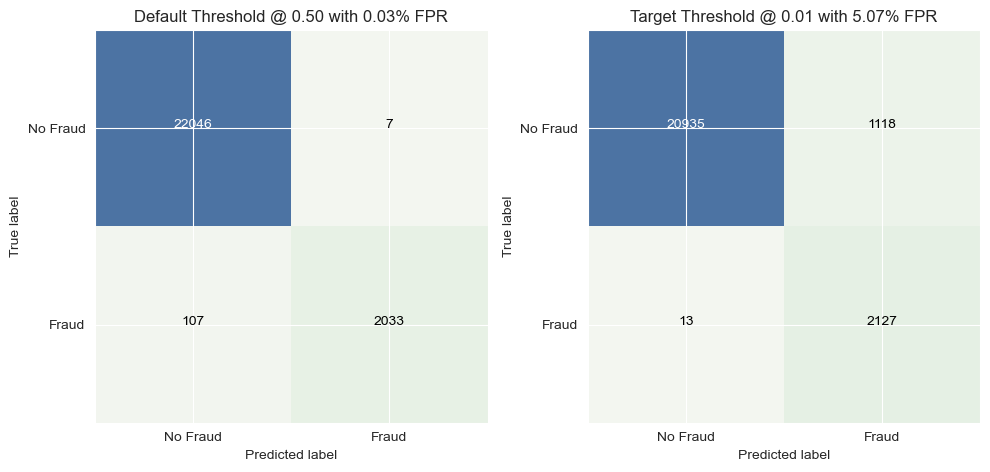

In [124]:
# Evaluate the XGBoost Classifier
fpr_xgb, tpr_xgb, default_recall_xgb, target_recall_xgb, default_predictive_equality_xgb, target_predictive_equality_xgb = evaluate_classifier(xgb_model, x_train_scaled, y_train, x_test_scaled, y_test, groups)

## 5. LGB

In [125]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_jobs=-1, random_state=42)

# Define a dictionary of hyperparameters for LGBMClassifier
lgb_params = {'lgbmclassifier__max_depth': [2, 4, 6, 8, 10], # 最大深度
               'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20], # 学习率
               'lgbmclassifier__n_estimators': [60, 80, 100, 140], # 迭代次数
               'lgbmclassifier__min_child_weight': [1, 2, 3, 4], # 最小叶子节点样本权重和
               'lgbmclassifier__subsample': [0.6, 0.8, 1.0], # 用于训练模型的子样本占整个样本集合的比例
               'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0] # 在建立树时对特征随机采样的比例
              }

lgb_model = train_classifier(lgb, lgb_params, x_train_scaled, y_train, categorical_feature_indices, search_type='random', scoring='f1',iterations=20)

print('\nbest params for lgb:',lgb_model.best_params_,'\n')

print(print_cv_results(lgb_model))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 87914, number of negative: 87914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5917
[LightGBM] [Info] Number of data points in the train set: 175828, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

best params for lgb: {'lgbmclassifier__subsample': 0.8, 'lgbmclassifier__n_estimators': 140, 'lgbmclassifier__min_child_weight': 1, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__colsample_bytree': 0.6} 

mean_test_score: 0.997189, params: {'lgbmclassifier__subsample': 0.8, 'lgbmclassifier__n_estimators': 140, 'lgbmclassifier__min_child_weight': 1, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__colsample_bytree'

Train Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87914
           1       1.00      1.00      1.00     87914

    accuracy                           1.00    175828
   macro avg       1.00      1.00      1.00    175828
weighted avg       1.00      1.00      1.00    175828

Default Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22053
           1       1.00      0.95      0.97      2140

    accuracy                           1.00     24193
   macro avg       1.00      0.98      0.99     24193
weighted avg       1.00      1.00      1.00     24193

Target Threshold @ 0.01:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22053
           1       0.65      0.99      0.79      2140

    accuracy                           0.95     24193
   macro avg       0.83      0.97      0.88     24193
weighted avg    

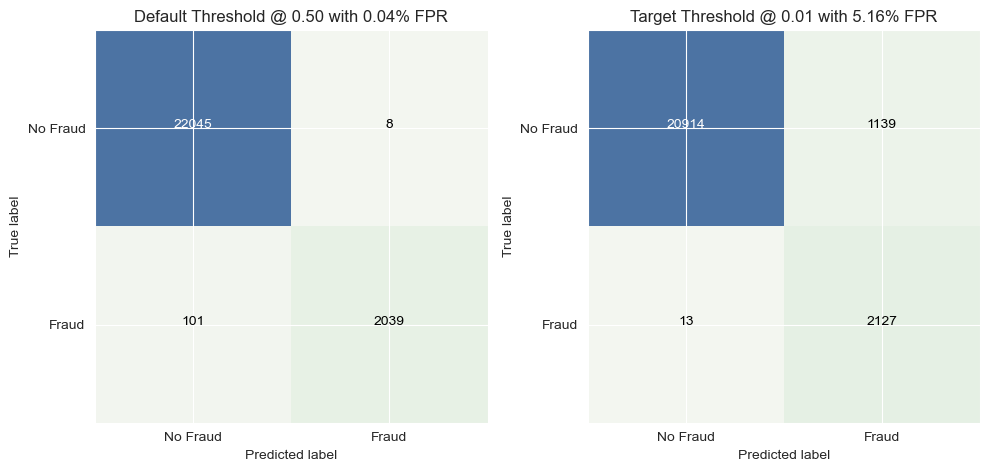

In [126]:
# Evaluate the LGBM Classifier
fpr_lgb, tpr_lgb, default_recall_lgb, target_recall_lgb, default_predictive_equality_lgb, target_predictive_equality_lgb = evaluate_classifier(lgb_model, x_train_scaled, y_train, x_test_scaled, y_test, groups)